# ULMFiT on French Amazon Customer Reviews
### (architecture QRNN, SentenPiece tokenizer)

- Author: [Pierre Guillou](https://www.linkedin.com/in/pierreguillou)
- Date: September 2019
- Post in medium: [link](https://medium.com/@pierre_guillou/nlp-fastai-french-language-model-d0e2a9e12cab)
- Ref: [Fastai v1](https://docs.fast.ai/) (Deep Learning library on PyTorch)

**Information**

According to this new article "[MultiFiT: Efficient Multi-lingual Language Model Fine-tuning](https://arxiv.org/abs/1909.04761)" (September 10, 2019), the QRNN architecture and the SentencePiece tokenizer give better results than AWD-LSTM and the spaCy tokenizer respectively. 

Therefore, they have been used in this notebook to **fine-tune a French bidirectional Language Model** by Transfer Learning of a French bidirectional Language Model (with the QRNN architecture and the SentencePiece tokenizer, too) trained on a Wikipedia corpus of 100 millions tokens ([lm2-french.ipynb](https://github.com/piegu/language-models/blob/master/lm2-french.ipynb)). 

This French bidirectional Language Model has been **fine-tuned on "[French Amazon Customer Reviews](https://s3.amazonaws.com/amazon-reviews-pds/readme.html)"** and **its encoder part has been transfered to a sentiment classifier which has been finally trained on this amazon corpus**.

This process **LM General --> LM fine-tuned --> Classifier fine-tuned** is called [ULMFiT](http://nlp.fast.ai/category/classification.html).

More, the following hyperparameters values given at the end of the MultiFiT article have been used:
- Language Model
    - (batch size) bs = 50
    - (QRNN) 3 QRNN (default: 3) with 1152 hidden parameters each one (default: 1152) (note: it would have been better to increae to 4 QRNN with 1550 hidden parameters like described in the article)
    - (SentencePiece) vocab of 15000 tokens
    - (dropout) mult_drop = 0
    - (weight decay) wd = 0.01
    - (number of training epochs) 10 epochs
    

- Sentiment Classifier
    - (batch size) bs = 18
    - (SentencePiece) vocab of 15000 tokens
    - (dropout) mult_drop = 0.5
    - (weight decay) wd = 0.01
    - (number of training epochs) 20 epochs
    - (loss) FlattenedLoss of weighted CrossEntropyLoss (the FlattenedLoss of LabelSmoothing CrossEntropy has been tested but was not kept because of a lower accuracy that could be a consequence of the fact that the dataset is unbalanced)

## Results

Our Bidirectional French LM ([lm-french.ipynb](https://github.com/piegu/language-models/blob/master/lm-french.ipynb)) and Sentiment Classifier with a AWD-LSTM architecture and using the spaCy tokenizer ([lm-french-classifier-amazon.ipynb](https://github.com/piegu/language-models/blob/master/lm-french-classifier-amazon.ipynb)) have better results (accuracy, perplexity and f1) than the Bidirectional French LM ([lm2-french.ipynb](https://github.com/piegu/language-models/blob/master/lm2-french.ipynb)) and Sentiment Classifier with a QRNN architecture and using the SentencePiecce tokenizer ([lm2-french-classifier-amazon.ipynb](https://github.com/piegu/language-models/blob/master/lm2-french-classifier-amazon.ipynb)). 

But because of the "To be improved" paragraph, we should retrain all in order to get a final comparaison.

### French Bidirectional LM (QRNN, SentencePiece)

- **About the data**: the dataset "French Amazon Customer Reviews" is unbalanced. Therefore, we used a weighted loss function (FlattenedLoss of weighted CrossEntropyLoss).
    - neg: 25637 (11.1%)
    - pos: 205047 (88.9%)


- **Accuracy and Perplexity** of the fine-tuned Language Model:    
    - forward : (accuracy) 35.79% | (perplexity) 28.97
    - backward: (global) 35.22% | (perplexity) 30.27
    

- **Accuracy** of the sentiment classifier:
    - forward : (global) 93.51% | **(neg) 93.69%** | (pos) 93.48%
    - backward: (global) 93.18% | (neg) 90.34% | (pos) 93.54%
    - ensemble: **(global) 93.70%** | (neg) 92.36% | **(pos) 93.86%**


- **f1 score** of the sentiment classifier:
    - forward: 0.9624
    - backward: 0.9606
    - ensemble: **0.9636**
    

(neg = negative reviews | pos = positive reviews)

### To be improved

Out of the 230 684 reviews of our file amazon_reviews_fr.csv, we found (but after the training of our models) that **11 098 reviews are not in French: almost 5%** (4.8%)!

We should delete these 11 098 review and re-fine-tune our LM and after our sentiment classifier on the only-French reviews dataset.

## Initialisation

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.text import *
from fastai.callbacks import *

In [5]:
from sklearn.metrics import f1_score

@np_func
def f1(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1))

In [6]:
# bs=48
# bs=24
bs=50

In [7]:
torch.cuda.set_device(0)

In [8]:
data_path = Config.data_path()

This will create a `{lang}wiki` folder, containing a `{lang}wiki` text file with the wikipedia contents. (For other languages, replace `{lang}` with the appropriate code from the [list of wikipedias](https://meta.wikimedia.org/wiki/List_of_Wikipedias).)

In [9]:
lang = 'fr'

In [10]:
name = f'{lang}wiki'
path = data_path/name
path.mkdir(exist_ok=True, parents=True)

lm_fns2 = [f'{lang}_wt_sp15', f'{lang}_wt_vocab_sp15']
lm_fns2_bwd = [f'{lang}_wt_sp15_bwd', f'{lang}_wt_vocab_sp15_bwd']

## Data

- [French Amazon Customer Reviews](https://s3.amazonaws.com/amazon-reviews-pds/readme.html)
- [Guide on how to download the French Amazon Customer Reviews](https://forums.fast.ai/t/ulmfit-french/29379/36)
- File: amazon_reviews_multilingual_FR_v1_00.tsv.gz

In [11]:
name = 'amazon_reviews_fr'
path_data = data_path/name
path_data.ls()

[PosixPath('/home/jupyter/.fastai/data/amazon_reviews_fr/amazon_reviews_multilingual_FR_v1_00.tsv'),
 PosixPath('/home/jupyter/.fastai/data/amazon_reviews_fr/amazon_reviews_fr.csv')]

### Run this code the first time

In [16]:
# to solve display error of pandas dataframe
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [17]:
fields = ['review_id', 'review_body', 'star_rating']
df = pd.read_csv(path_data/'amazon_reviews_multilingual_FR_v1_00.tsv', delimiter='\t',encoding='utf-8', usecols=fields)
df = df[fields]
df.loc[pd.isna(df.review_body),'review_body']='NA'
df.head()

,review_id,review_body,star_rating
0,R32VYUWDIB5LKE,je conseille fortement ce bouquin à ceux qui s...,5
1,R3CCMP4EV6HAVL,"ce magnifique est livre , les personnages sont...",5
2,R14NAE6UGTVTA2,Je dirais qu'il a un défaut :<br />On ne peut ...,3
3,R2E7QEWSC6EWFA,Je l'ai depuis quelques jours et j'en suis trè...,4
4,R26E6I47GQRYKR,"je m'attendait à un bon film, car j'aime beauc...",2


In [18]:
# number of reviews
print(f'number of reviews: {len(df)}')

# check that there is no twice the same review
same = len(df) - len(df['review_id'].unique())
print(f'number of identical reviews: {same}')

# number of reviews neg or pos
num_neg_pos = len(df[df['star_rating'] != 3])
print(f'number of reviews neg + pos (rating != 3): {num_neg_pos}')

number of reviews: 253961
number of identical reviews: 0
number of reviews neg + pos (rating != 3): 230684


In [20]:
list(df_trn_val['label'].value_counts().array)

[205047, 25637]

pos    205047
neg     25637
Name: label, dtype: int64


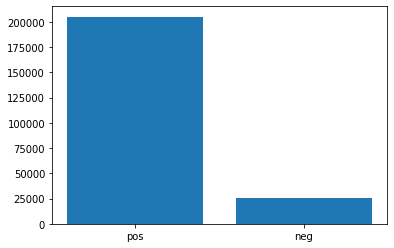

In [21]:
# categorify reviews in 2 classes neg, pos in the label column (rating != 3)
df_trn_val = df[df['star_rating'] != 3].copy()
df_trn_val['label'] = 'neg'
df_trn_val.loc[df_trn_val['star_rating'] > 3, 'label'] = 'pos'

# plot histogram
x= [1,2]
keys = list(df_trn_val['label'].value_counts().keys())
values = list(df_trn_val['label'].value_counts().array)
plt.bar(x, values) 
plt.xticks(x, keys)
print(df_trn_val['label'].value_counts())
plt.show()

In [38]:
df_trn_val.to_csv (path_data/'amazon_reviews_fr.csv', index = None, header=True)

### Get the csv of pre-processed data 

In [12]:
df_trn_val = pd.read_csv(path_data/'amazon_reviews_fr.csv')

### Check that the text language of each review is French and delete the non French ones

In [13]:
from langdetect import detect, detect_langs

In [14]:
df = pd.read_csv(path_data/'amazon_reviews_fr.csv')

In [15]:
# to solve display error of pandas dataframe
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [16]:
df.head()

,review_id,review_body,star_rating,label
0,R32VYUWDIB5LKE,je conseille fortement ce bouquin à ceux qui s...,5,pos
1,R3CCMP4EV6HAVL,"ce magnifique est livre , les personnages sont...",5,pos
2,R2E7QEWSC6EWFA,Je l'ai depuis quelques jours et j'en suis trè...,4,pos
3,R26E6I47GQRYKR,"je m'attendait à un bon film, car j'aime beauc...",2,neg
4,R1RJMTSNCKB9LP,Ne disait pas sur l'annonce que c'était un 10'...,2,neg


In [27]:
%%time
list_idx = []
for idx, row in df.iterrows():
    try:
        language = detect(row['review_body'])
    except:
        language = "error"   
    if language != 'fr':
        list_idx.append(idx)

CPU times: user 18min 31s, sys: 11 s, total: 18min 42s
Wall time: 18min 43s


In [28]:
len(df), len(list_idx)

(230684, 11098)

In [29]:
df["review_body"][list_idx][:10]

15     Just great complination, there are 48 cds insi...
18     I know it's a classic but really it is a marve...
19     Waiting for so long to get a sequel of Bridget...
66     Not one of his best science fiction novels but...
117    Für die  Liebhaber von Schwarzer Humor  ist di...
151    A great alternate look into the world of cats,...
175    It's the perfect book for a screenwriter and a...
214    Good delivery, on time. However the image of t...
324    This is Frank Herbert's masterpiece and should...
327    It was by sheer chance that I came across this...
Name: review_body, dtype: object

In [30]:
df2 = df.copy()

In [31]:
df2 = df.copy()
df2.drop(list_idx, axis=0, inplace=True)

In [32]:
len(df2)

219586

## Fine-tuning "forward LM"

### Databunch

In [17]:
%%time
data_lm = (TextList.from_df(df_trn_val, path, cols='review_body', 
                            processor=[OpenFileProcessor(), SPProcessor(max_vocab_sz=15000)])
    .split_by_rand_pct(0.1, seed=42)
    .label_for_lm()           
    .databunch(bs=bs, num_workers=1))

CPU times: user 7min 1s, sys: 3.93 s, total: 7min 5s
Wall time: 3min 27s


In [18]:
data_lm.save(f'{path}/{lang}_databunch_lm_aws_sp15')

### Training

In [11]:
data_lm = load_data(path, f'{lang}_databunch_lm_aws_sp15', bs=bs)

In [12]:
config = awd_lstm_lm_config.copy()
config['qrnn'] = True

In [13]:
%%time
perplexity = Perplexity()
learn_lm = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained_fnames=lm_fns2, drop_mult=0.3, 
                                  metrics=[error_rate, accuracy, perplexity]).to_fp16()

CPU times: user 4.04 s, sys: 1.71 s, total: 5.75 s
Wall time: 6.54 s


In [21]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


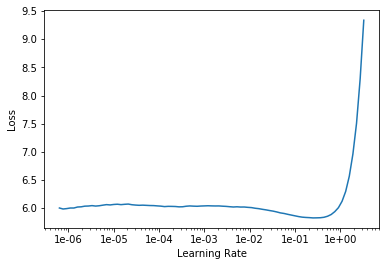

In [22]:
learn_lm.recorder.plot()

In [23]:
lr = 1e-3
lr *= bs/48

wd = 0.01

In [24]:
learn_lm.fit_one_cycle(2, lr*10, wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,4.364937,4.127997,0.728301,0.271699,62.053352,02:20
1,4.188382,3.942470,0.710881,0.289120,51.545666,02:20


In [25]:
learn_lm.save(f'{lang}fine_tuned1_sp15')
learn_lm.save_encoder(f'{lang}fine_tuned1_enc_sp15')

In [26]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(18, lr, wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,3.975761,3.833473,0.699623,0.300377,46.222725,03:09
1,3.848893,3.728329,0.687341,0.312659,41.609566,03:09
2,3.721791,3.643100,0.677313,0.322686,38.210094,03:09
3,3.683572,3.585832,0.670209,0.329791,36.083378,03:10
4,3.627503,3.545522,0.665744,0.334256,34.657887,03:09
5,3.588596,3.513960,0.661785,0.338215,33.581036,03:09
6,3.559013,3.486362,0.658416,0.341584,32.666874,03:09
7,3.530540,3.464996,0.655928,0.344072,31.976351,03:09
8,3.486778,3.447401,0.653625,0.346374,31.418600,03:09
9,3.500075,3.430552,0.651237,0.348763,30.893700,03:08


In [9]:
# perplexity
val_loss = 3.366147
np.exp(val_loss)

28.966703060315766

In [27]:
learn_lm.save(f'{lang}fine_tuned2_sp15')
learn_lm.save_encoder(f'{lang}fine_tuned2_enc_sp15')

Save best LM learner and its encoder

In [15]:
learn_lm.save(f'{lang}fine_tuned_sp15')
learn_lm.save_encoder(f'{lang}fine_tuned_enc_sp15')

## Fine-tuning "backward LM"

### Databunch

In [10]:
%%time
data_lm = (TextList.from_df(df_trn_val, path, cols='review_body', 
                            processor=[OpenFileProcessor(), SPProcessor(max_vocab_sz=15000)])
    .split_by_rand_pct(0.1, seed=42)
    .label_for_lm()           
    .databunch(bs=bs, num_workers=1, backwards=True))

CPU times: user 7min 6s, sys: 3.71 s, total: 7min 10s
Wall time: 3min 37s


In [11]:
data_lm.save(f'{path}/{lang}_databunch_lm_aws_sp15_bwd')

### Training

In [21]:
%%time
data_lm = load_data(path, f'{lang}_databunch_lm_aws_sp15_bwd', bs=bs, backwards=True)

CPU times: user 2.41 s, sys: 196 ms, total: 2.61 s
Wall time: 2.61 s


In [22]:
config = awd_lstm_lm_config.copy()
config['qrnn'] = True

In [23]:
%%time
perplexity = Perplexity()
learn_lm = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained_fnames=lm_fns2_bwd, drop_mult=0.3, 
                                  metrics=[error_rate, accuracy, perplexity]).to_fp16()

CPU times: user 928 ms, sys: 196 ms, total: 1.12 s
Wall time: 544 ms


In [15]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


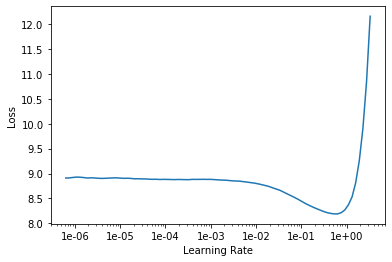

In [16]:
learn_lm.recorder.plot()

In [17]:
lr = 1e-3
lr *= bs/48

wd = 0.01

In [18]:
learn_lm.fit_one_cycle(2, lr*10, wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,4.793482,4.527842,0.768429,0.231571,92.558655,02:31
1,4.632069,4.341979,0.753315,0.246686,76.859566,02:31


In [19]:
learn_lm.save(f'{lang}fine_tuned1_sp15_bwd')
learn_lm.save_encoder(f'{lang}fine_tuned1_enc_sp15_bwd')

In [20]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(18, lr, wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,4.296514,4.161376,0.736233,0.263767,64.159561,03:23
1,4.130993,3.987864,0.716614,0.283386,53.939629,03:22
2,3.956398,3.833526,0.698954,0.301046,46.225235,03:22
3,3.807486,3.726387,0.686238,0.313763,41.528687,03:22
4,3.754490,3.651143,0.678229,0.321771,38.518734,03:20
5,3.655463,3.600486,0.672112,0.327887,36.615993,03:21
6,3.633501,3.560688,0.667255,0.332745,35.187481,03:21
7,3.603338,3.529700,0.663621,0.336379,34.113655,03:21
8,3.567799,3.505535,0.660722,0.339277,33.299282,03:22
9,3.557265,3.483793,0.658104,0.341895,32.583061,03:21


In [19]:
# perplexity
val_loss = 3.410233
np.exp(val_loss)

30.27229688291125

In [21]:
learn_lm.save(f'{lang}fine_tuned2_sp15_bwd')
learn_lm.save_encoder(f'{lang}fine_tuned2_enc_sp15_bwd')

Save best LM learner and its encoder

In [26]:
learn_lm.save(f'{lang}fine_tuned_sp15_bwd')
learn_lm.save_encoder(f'{lang}fine_tuned_enc_sp15_bwd')

## Fine-tuning "forward Classifier"

In [10]:
bs = 18

### Databunch

In [27]:
%%time
data_lm = load_data(path, f'{lang}_databunch_lm_aws_sp15', bs=bs)

CPU times: user 2.16 s, sys: 408 ms, total: 2.56 s
Wall time: 2.56 s


In [24]:
%%time
data_clas = (TextList.from_df(df_trn_val, path, vocab=data_lm.vocab, cols='review_body', 
                              processor=[OpenFileProcessor(), SPProcessor(max_vocab_sz=15000)])
    .split_by_rand_pct(0.1, seed=42)
    .label_from_df(cols='label')
    .databunch(bs=bs, num_workers=1))

CPU times: user 7min 10s, sys: 4.84 s, total: 7min 15s
Wall time: 4min 10s


In [25]:
%%time
data_clas.save(f'{lang}_textlist_class_sp15')

CPU times: user 5.52 s, sys: 1.03 s, total: 6.55 s
Wall time: 6.06 s


### Get weights to penalize loss function of the majority class

In [11]:
%%time
data_clas = load_data(path, f'{lang}_textlist_class_sp15', bs=bs, num_workers=1)

CPU times: user 11.9 s, sys: 832 ms, total: 12.7 s
Wall time: 12.5 s


In [12]:
num_trn = len(data_clas.train_ds.x)
num_val = len(data_clas.valid_ds.x)
num_trn, num_val, num_trn+num_val

(207616, 23068, 230684)

In [13]:
trn_LabelCounts = np.unique(data_clas.train_ds.y.items, return_counts=True)[1]
val_LabelCounts = np.unique(data_clas.valid_ds.y.items, return_counts=True)[1]
trn_LabelCounts, val_LabelCounts

(array([ 23071, 184545]), array([ 2566, 20502]))

In [14]:
trn_weights = [1 - count/num_trn for count in trn_LabelCounts]
val_weights = [1 - count/num_val for count in val_LabelCounts]
trn_weights, val_weights

([0.888876579839704, 0.11112342016029597],
 [0.8887636552800416, 0.11123634471995836])

### Training (Loss = FlattenedLoss of weighted CrossEntropyLoss)

In [61]:
%%time
data_clas = load_data(path, f'{lang}_textlist_class_sp15', bs=bs, num_workers=1)

CPU times: user 12.6 s, sys: 284 ms, total: 12.9 s
Wall time: 12.8 s


In [62]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True

In [63]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, pretrained=False, drop_mult=0.5, 
                                  metrics=[accuracy,f1]).to_fp16()
learn_c.load_encoder(f'{lang}fine_tuned_enc_sp15');

#### Change loss function

In [64]:
learn_c.loss_func

FlattenedLoss of CrossEntropyLoss()

In [65]:
loss_weights = torch.FloatTensor(trn_weights).cuda()
learn_c.loss_func = partial(F.cross_entropy, weight=loss_weights)

In [66]:
learn_c.loss_func

functools.partial(<function cross_entropy at 0x7f30905a4200>, weight=tensor([0.8889, 0.1111], device='cuda:0'))

#### Training

In [92]:
learn_c.freeze()

In [93]:
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


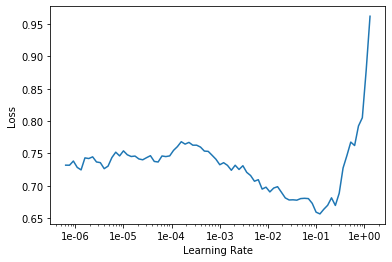

In [94]:
learn_c.recorder.plot()

In [42]:
lr = 2e-2
lr *= bs/48

wd = 0.01

In [43]:
learn_c.fit_one_cycle(2, lr, wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.437175,0.282718,0.864618,0.914374,02:58
1,0.387293,0.260588,0.876972,0.922479,02:56


In [44]:
learn_c.save(f'{lang}clas1_sp15')

In [45]:
learn_c.load(f'{lang}clas1_sp15');
learn_c.fit_one_cycle(2, lr, wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.433597,0.279311,0.875412,0.920975,02:50
1,0.366492,0.256188,0.887030,0.929599,02:45


In [46]:
learn_c.save(f'{lang}clas2_sp15')

In [48]:
learn_c.load(f'{lang}clas2_sp15');
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.352552,0.237124,0.947416,0.968906,03:27
1,0.279644,0.209162,0.946463,0.968271,03:34


In [49]:
learn_c.save(f'{lang}clas3_sp15')

In [50]:
learn_c.load(f'{lang}clas3_sp15');
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.283462,0.184935,0.924007,0.953850,04:03
1,0.217490,0.181429,0.934368,0.960415,04:18


In [51]:
learn_c.save(f'{lang}clas4_sp15')

In [52]:
learn_c.load(f'{lang}clas4_sp15');
learn_c.unfreeze()
learn_c.fit_one_cycle(1, slice(lr/10/(2.6**4),lr/10), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.219500,0.176016,0.935062,0.960744,04:49


In [53]:
learn_c.save(f'{lang}clas5_sp15')

In [54]:
learn_c.load(f'{lang}clas5_sp15')
learn_c.save(f'{lang}clas_sp15')

In [67]:
learn_c.load(f'{lang}clas_sp15');
learn_c.to_fp32().export(f'{lang}_classifier_sp15')

### Training (Loss = FlattenedLoss of LabelSmoothing CrossEntropy)

In [53]:
%%time
data_clas = load_data(path, f'{lang}_textlist_class_sp15', bs=bs, num_workers=1)

CPU times: user 12.5 s, sys: 200 ms, total: 12.7 s
Wall time: 12.7 s


In [54]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True

In [55]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, pretrained=False, drop_mult=0.5, 
                                  metrics=[accuracy,f1]).to_fp16()
learn_c.load_encoder(f'{lang}fine_tuned_enc_sp15');

#### Change loss function

In [56]:
learn_c.loss_func

FlattenedLoss of CrossEntropyLoss()

In [57]:
learn_c.loss_func = FlattenedLoss(LabelSmoothingCrossEntropy)

In [58]:
learn_c.loss_func

FlattenedLoss of LabelSmoothingCrossEntropy()

#### Training

In [52]:
learn_c.freeze()

In [103]:
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


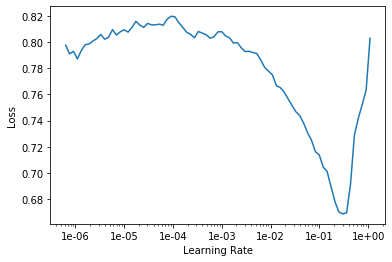

In [104]:
learn_c.recorder.plot()

In [105]:
lr = 2e-2
lr *= bs/48

wd = 0.01

In [109]:
from fastai.callbacks import *

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.810097,0.690017,0.581065,0.708460,03:20
1,0.801332,0.692924,0.577293,0.705548,03:09


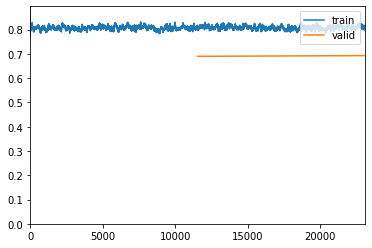

Better model found at epoch 0 with accuracy value: 0.5810647010803223.


In [110]:
learn_c.fit_one_cycle(2, lr, wd=wd, moms=(0.8,0.7), 
                      callbacks=[ShowGraph(learn_c),
                                 SaveModelCallback(learn_c.to_fp32(),every='improvement',mode='max',monitor='accuracy',
                                                   name='bestmodel_clas_sp15_labelsmoothing')])

In [111]:
learn_c.save(f'{lang}clas1_sp15_labelsmoothing')

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.810106,0.669316,0.607031,0.732028,03:08
1,0.801576,0.667449,0.610543,0.735263,03:15


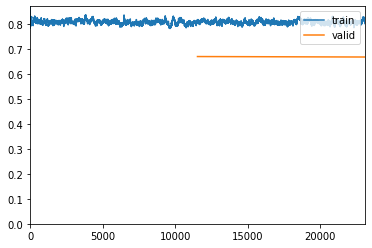

Better model found at epoch 0 with accuracy value: 0.6070314049720764.
Better model found at epoch 1 with accuracy value: 0.6105427145957947.


In [114]:
learn_c.load(f'{lang}clas1_sp15_labelsmoothing');
learn_c.fit_one_cycle(2, lr, wd=wd, moms=(0.8,0.7), 
                      callbacks=[ShowGraph(learn_c),
                                 SaveModelCallback(learn_c.to_fp32(),every='improvement',mode='max',
                                                   monitor='accuracy',name='bestmodel_clas_sp15_labelsmoothing')])

In [115]:
learn_c.save(f'{lang}clas2_sp15_labelsmoothing')

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.317804,0.280220,0.951968,0.972167,03:25
1,0.314769,0.274971,0.953008,0.972907,03:45


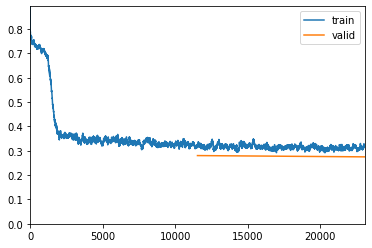

Better model found at epoch 0 with accuracy value: 0.9519680738449097.
Better model found at epoch 1 with accuracy value: 0.9530084729194641.


In [116]:
learn_c.load(f'{lang}clas2_sp15_labelsmoothing');
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), wd=wd, moms=(0.8,0.7), 
                      callbacks=[ShowGraph(learn_c),
                                 SaveModelCallback(learn_c.to_fp32(),every='improvement',mode='max',
                                                   monitor='accuracy',name='bestmodel_clas_sp15_labelsmoothing')])

In [117]:
learn_c.save(f'{lang}clas3_sp15_labelsmoothing')

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.301391,0.272535,0.959598,0.976547,04:16
1,0.291589,0.270674,0.961332,0.977425,04:29


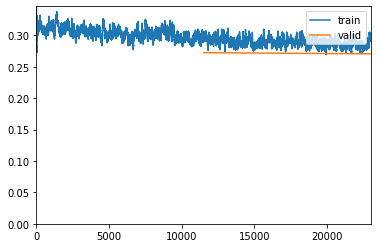

Better model found at epoch 0 with accuracy value: 0.9595977067947388.
Better model found at epoch 1 with accuracy value: 0.9613317251205444.


In [118]:
learn_c.load(f'{lang}clas3_sp15_labelsmoothing');
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), wd=wd, moms=(0.8,0.7), 
                      callbacks=[ShowGraph(learn_c),
                                 SaveModelCallback(learn_c.to_fp32(),every='improvement',mode='max',monitor='accuracy',
                                                   name='bestmodel_clas_sp15_labelsmoothing')])

In [119]:
learn_c.save(f'{lang}clas4_sp15_labelsmoothing')

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.290772,0.268086,0.962979,0.978403,06:32


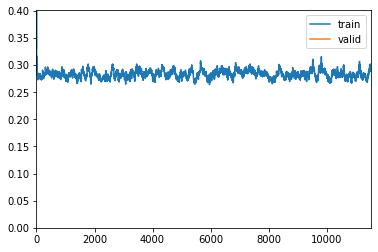

Better model found at epoch 0 with accuracy value: 0.9629790186882019.


In [120]:
learn_c.load(f'{lang}clas4_sp15_labelsmoothing');
learn_c.unfreeze()
learn_c.fit_one_cycle(1, slice(lr/10/(2.6**4),lr/10), wd=wd, moms=(0.8,0.7), 
                      callbacks=[ShowGraph(learn_c),
                                 SaveModelCallback(learn_c.to_fp32(),every='improvement',mode='max',monitor='accuracy',
                                                   name='bestmodel_clas_sp15_labelsmoothing')])

In [121]:
learn_c.save(f'{lang}clas5_sp15_labelsmoothing')

In [122]:
learn_c.load(f'{lang}clas5_sp15_labelsmoothing');
learn_c.save(f'{lang}clas_sp15_labelsmoothing')

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.281384,0.265413,0.962849,0.978329,06:18
1,0.275690,0.285689,0.964106,0.979017,06:17
2,0.273247,0.272905,0.964280,0.979153,06:04


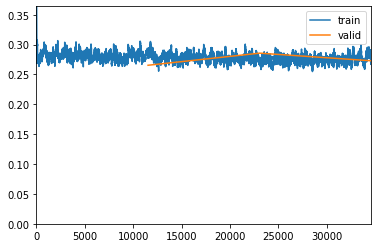

Better model found at epoch 0 with accuracy value: 0.962848961353302.
Better model found at epoch 1 with accuracy value: 0.9641061425209045.
Better model found at epoch 2 with accuracy value: 0.9642795324325562.


In [123]:
learn_c.load(f'{lang}clas5_sp15_labelsmoothing');
learn_c.fit_one_cycle(3, slice(lr/10/(2.6**4),lr/10), wd=wd, moms=(0.8,0.7), 
                      callbacks=[ShowGraph(learn_c),
                                 SaveModelCallback(learn_c.to_fp32(),every='improvement',mode='max',monitor='accuracy',
                                                   name='bestmodel_clas_sp15_labelsmoothing')])

In [124]:
learn_c.save(f'{lang}clas6_sp15_labelsmoothing')

In [59]:
learn_c.load(f'{lang}clas6_sp15_labelsmoothing');
learn_c.save(f'{lang}clas_sp15_labelsmoothing')

In [60]:
learn_c.load(f'{lang}clas_sp15_labelsmoothing');
learn_c.to_fp32().export(f'{lang}_classifier_sp15_labelsmoothing')

### Confusion matrix

In [25]:
%%time
data_clas = load_data(path, f'{lang}_textlist_class_sp15', bs=bs, num_workers=1)

config = awd_lstm_clas_config.copy()
config['qrnn'] = True

learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, pretrained=False, drop_mult=0.5, 
                                  metrics=[accuracy,f1])
learn_c.load_encoder(f'{lang}fine_tuned_enc_sp15');

learn_c.load(f'{lang}clas_sp15');

# put weight on cpu
loss_weights = torch.FloatTensor(trn_weights).cpu()
learn_c.loss_func = partial(F.cross_entropy, weight=loss_weights)

CPU times: user 13.3 s, sys: 512 ms, total: 13.8 s
Wall time: 13 s


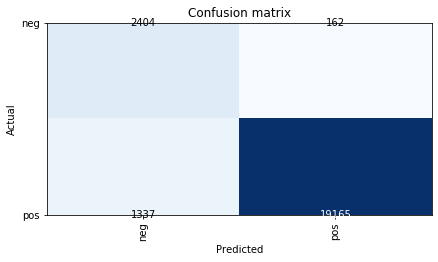

In [43]:
preds,y,losses = learn_c.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

interp = ClassificationInterpretation(learn_c, preds, y, losses)
interp.plot_confusion_matrix()

In [29]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.array(y), np.array(predictions))
print(cm)

## acc
print(f'accuracy global: {(cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])}')

# acc neg, acc pos
print(f'accuracy on negative reviews: {cm[0,0]/(cm[0,0]+cm[0,1])*100}') 
print(f'accuracy on positive reviews: {cm[1,1]/(cm[1,0]+cm[1,1])*100}')

[[ 2404   162]
 [ 1337 19165]]
accuracy global: 0.9350182070400554
accuracy on negative reviews: 93.68667186282151
accuracy on positive reviews: 93.47868500634084


In [36]:
learn_c.show_results()

text,target,prediction
"▁xxbos ▁xxmaj ▁voila ▁une ▁intégrale ▁bienvenue ▁que ▁xxup ▁decca ▁sort ▁judicieusement ▁de ▁ses ▁carton s , ▁ce ▁ne ▁sont ▁que ▁des ▁enregistrements ▁de ▁qualité ▁de ▁l ' immense ▁pianiste ▁( dont ▁de ▁nombreux ▁introuvable s ). ▁xxmaj ▁ses ▁concertos ▁de ▁xxmaj ▁beethoven ▁avec ▁xxmaj ▁ kn apper ts bus ch ▁sont ▁fabuleux ▁tout ▁comme ▁les ▁deux ▁concertos ▁de ▁xxmaj ▁brahms , ▁pour ▁moi ▁la ▁meilleure ▁version ▁jamais ▁enregistrée . ▁xxmaj",pos,pos
▁xxbos ▁h tt p : ▁/ ▁/ ▁w ww . amazon . co . uk ▁/ ▁sony - ber n stein - edition ▁/ ▁for um ▁/ ▁ fx 1 n p 1 l t py n 3 x 6 c ▁/ ▁ t x 2 ry vi 6 c j hy mes ▁/ ▁1 ? _ en co ding = ut f 8 & asin = b 00 ll,pos,pos
"▁xxbos ▁xxmaj ▁même ▁si ▁je ▁vais ▁me ▁faire ▁des ▁ennemis , ▁je ▁persiste ▁et ▁signe , ▁xxmaj ▁pierce ▁xxmaj ▁brosnan ▁est ▁crédible ▁dans ▁le ▁rôle , s e an ▁xxmaj ▁connery ▁l ' acteur ▁fondateur ▁du ▁rôle ▁titre , ▁donc ▁ intouchable , ▁xxmaj ▁george ▁xxmaj ▁la z en by ▁et ▁xxmaj ▁thi mo thy ▁xxmaj ▁d al ton , ▁crédibles ▁malgré ▁un ▁passage ▁très ▁court ▁( ▁1 ▁film ▁pour",pos,pos
"▁xxbos ▁xxmaj ▁wa ou h , ▁au ▁boulot . ▁xxmaj ▁je ▁re ç ois ▁ce ▁bloc ▁( di vin , ▁salut ▁xxmaj ▁vol odi a !) ▁- ▁et , ▁je ▁le ▁souligne , ▁à ▁20 ▁euros ▁de ▁moins ▁que ▁proposé ▁ici ▁en ▁passant ▁par ▁un ▁vendeur ▁d ' amazon ▁xxup ▁uk ▁- ▁alors ▁même ▁que ▁j ' ent a mais ▁( tra î nais ▁depuis ▁un ▁moment , ▁je ▁suis",pos,pos
"▁xxbos ▁xxmaj ▁tout ▁y ▁est , ▁l ' histoire , ▁la ▁réalisation ▁du ▁très ▁grand ▁xxup ▁ridley ▁xxup ▁scott , ▁xxmaj ▁les ▁acteurs ▁et ▁surtout ▁xxup ▁russell ▁xxup ▁crowe , ▁xxmaj ▁les ▁xxmaj ▁décors , ▁enfin ▁tout ▁et ▁surtout ▁en ▁version ▁longue . ▁xxmaj ▁ gladiator ▁( ou ▁xxmaj ▁gladiateur ▁au ▁xxmaj ▁québec ▁et ▁au ▁nouveau - br un s wick ) ▁est ▁un ▁film ▁ américan o - br",pos,pos


In [40]:
# Trying out some random sentences I made up

review = 'Ce produit est bizarre.'
pred = learn_c.predict(review)
print(pred[0], pred[2])

neg tensor([0.9970, 0.0030])


## Fine-tuning "backward Classifier"

In [44]:
bs = 18

### Databunch

In [46]:
%%time
data_lm = load_data(path, f'{lang}_databunch_lm_aws_sp15_bwd', bs=bs, backwards=True)

CPU times: user 2.42 s, sys: 376 ms, total: 2.79 s
Wall time: 2.79 s


In [47]:
%%time
data_clas = (TextList.from_df(df_trn_val, path, vocab=data_lm.vocab, cols='review_body', 
                              processor=[OpenFileProcessor(), SPProcessor(max_vocab_sz=15000)])
    .split_by_rand_pct(0.1, seed=42)
    .label_from_df(cols='label')
    .databunch(bs=bs, num_workers=1, backwards=True))

CPU times: user 7min 26s, sys: 7.3 s, total: 7min 33s
Wall time: 4min 29s


In [48]:
%%time
data_clas.save(f'{lang}_textlist_class_sp15_bwd')

CPU times: user 5.9 s, sys: 1.1 s, total: 7 s
Wall time: 7.49 s


### Get weights to penalize loss function of the majority class

In [49]:
%%time
data_clas = load_data(path, f'{lang}_textlist_class_sp15_bwd', bs=bs, num_workers=1, backwards=True)

CPU times: user 13.2 s, sys: 432 ms, total: 13.6 s
Wall time: 13 s


In [50]:
num_trn = len(data_clas.train_ds.x)
num_val = len(data_clas.valid_ds.x)
num_trn, num_val, num_trn+num_val

(207616, 23068, 230684)

In [51]:
trn_LabelCounts = np.unique(data_clas.train_ds.y.items, return_counts=True)[1]
val_LabelCounts = np.unique(data_clas.valid_ds.y.items, return_counts=True)[1]
trn_LabelCounts, val_LabelCounts

(array([ 23071, 184545]), array([ 2566, 20502]))

In [52]:
trn_weights = [1 - count/num_trn for count in trn_LabelCounts]
val_weights = [1 - count/num_val for count in val_LabelCounts]
trn_weights, val_weights

([0.888876579839704, 0.11112342016029597],
 [0.8887636552800416, 0.11123634471995836])

### Training (Loss = FlattenedLoss of weighted CrossEntropyLoss)

In [66]:
%%time
data_clas = load_data(path, f'{lang}_textlist_class_sp15_bwd', bs=bs, num_workers=1, backwards=True)

CPU times: user 12.6 s, sys: 424 ms, total: 13 s
Wall time: 12.9 s


In [67]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True

In [68]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, drop_mult=0.5, metrics=[accuracy,f1]).to_fp16()
learn_c.load_encoder(f'{lang}fine_tuned_enc_sp15_bwd');

#### Change loss function

In [69]:
learn_c.loss_func

FlattenedLoss of CrossEntropyLoss()

In [70]:
loss_weights = torch.FloatTensor(trn_weights).cuda()
learn_c.loss_func = partial(F.cross_entropy, weight=loss_weights)

In [71]:
learn_c.loss_func

functools.partial(<function cross_entropy at 0x7f6389801200>, weight=tensor([0.8889, 0.1111], device='cuda:0'))

#### Training

In [72]:
learn_c.freeze()

In [ ]:
learn_c.lr_find()

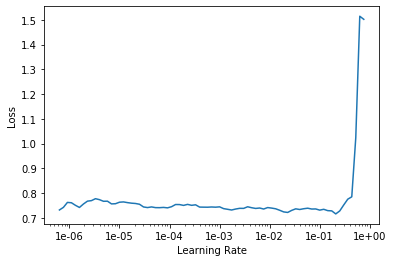

In [74]:
learn_c.recorder.plot()

In [75]:
lr = 2e-2
lr *= bs/48

wd = 0.01

In [76]:
learn_c.fit_one_cycle(2, lr, wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.501302,0.387383,0.823348,0.885338,02:57
1,0.523619,0.373636,0.802974,0.871117,03:04


In [77]:
learn_c.save(f'{lang}clas1_sp15_bwd')

In [78]:
learn_c.load(f'{lang}clas1_sp15_bwd');
learn_c.fit_one_cycle(2, lr, wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.468178,0.407151,0.740550,0.822256,02:52
1,0.457562,0.391507,0.795084,0.865942,03:05


In [79]:
learn_c.save(f'{lang}clas2_sp15_bwd')

In [80]:
learn_c.load(f'{lang}clas2_sp15_bwd');
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.391392,0.283015,0.895570,0.936219,03:39
1,0.363020,0.253934,0.898908,0.938087,03:27


In [81]:
learn_c.save(f'{lang}clas3_sp15_bwd')

In [82]:
learn_c.load(f'{lang}clas3_sp15_bwd');
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.332751,0.218908,0.912043,0.946311,04:13
1,0.285485,0.208085,0.915641,0.948510,04:21


In [83]:
learn_c.save(f'{lang}clas4_sp15_bwd')

In [84]:
learn_c.load(f'{lang}clas4_sp15_bwd');
learn_c.unfreeze()
learn_c.fit_one_cycle(1, slice(lr/10/(2.6**4),lr/10), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.254880,0.205224,0.922057,0.952664,04:55


In [85]:
learn_c.load(f'{lang}clas4_sp15_bwd');
learn_c.unfreeze()
learn_c.fit_one_cycle(1, slice(lr/10/(2.6**4),lr/10), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.273147,0.203318,0.931810,0.958756,05:32


In [86]:
learn_c.save(f'{lang}clas5_sp15_bwd')

In [87]:
learn_c.load(f'{lang}clas5_sp15_bwd')
learn_c.save(f'{lang}clas_sp15_bwd')

In [88]:
learn_c.load(f'{lang}clas_sp15_bwd');
learn_c.to_fp32().export(f'{lang}_classifier_sp15_bwd')

### Confusion matrix

In [89]:
%%time
data_clas = load_data(path, f'{lang}_textlist_class_sp15_bwd', bs=bs, num_workers=1, backwards=True)

config = awd_lstm_clas_config.copy()
config['qrnn'] = True

learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, drop_mult=0.5, 
                                  metrics=[accuracy,f1])
learn_c.load_encoder(f'{lang}fine_tuned_enc_sp15_bwd');

learn_c.load(f'{lang}clas_sp15_bwd');

# put weight on cpu
loss_weights = torch.FloatTensor(trn_weights).cpu()
learn_c.loss_func = partial(F.cross_entropy, weight=loss_weights)

CPU times: user 16 s, sys: 1.11 s, total: 17.1 s
Wall time: 15.2 s


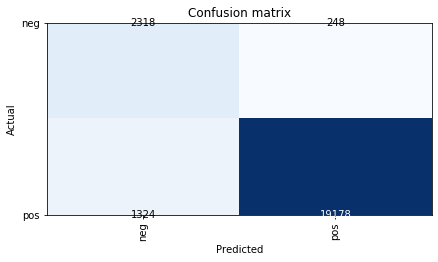

In [90]:
preds,y,losses = learn_c.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

interp = ClassificationInterpretation(learn_c, preds, y, losses)
interp.plot_confusion_matrix()

In [91]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.array(y), np.array(predictions))
print(cm)

## acc
print(f'accuracy global: {(cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])}')

# acc neg, acc pos
print(f'accuracy on negative reviews: {cm[0,0]/(cm[0,0]+cm[0,1])*100}') 
print(f'accuracy on positive reviews: {cm[1,1]/(cm[1,0]+cm[1,1])*100}')

[[ 2318   248]
 [ 1324 19178]]
accuracy global: 0.9318536500780302
accuracy on negative reviews: 90.33515198752923
accuracy on positive reviews: 93.54209345429713


In [92]:
learn_c.show_results()

text,target,prediction
on z ur ▁c ▁xxmaj ord ▁cliff ▁xxmaj 39 : ▁7 po ▁trop ▁non ▁ma allegro ▁ ▁xxmaj . 4 . ▁50 :14 ▁14 ) za ez cat li ▁de ▁con ce viva ▁ allegro ▁( zo cher s ▁ ▁xxmaj ▁3. . 49 ▁ 17 : ▁9 to tenu s ▁so ante ▁and ▁xxmaj ▁2. . 48 ▁ 12 : ▁13 to ra ▁mode to mol ▁ ▁xxmaj ▁1.,pos,pos
"▁m : "" ▁figaro ▁xxmaj ▁of ▁marriage ▁xxmaj the ▁"" overture ▁ ▁xxmaj ) ▁1968 , ▁york ▁xxmaj ▁new ▁xxmaj , ▁5 arch m ▁( ] 77 disc ▁[ ▁philharmonic ▁xxmaj ▁york ▁xxmaj ▁new ▁xxmaj ] ing play ▁[ ri ra ▁fer ▁xxmaj ▁= ▁w : "" ▁madonna ▁xxmaj ▁of wel je ▁"" interlude ▁ ▁- ) ▁1968 , ▁2 ary u br ▁fe ▁xxmaj known un ▁( ) ▁hall",pos,pos
"▁"" ▁\ ▁name ▁xxmaj ▁my ▁xxmaj ▁know ▁xxmaj you ▁"" ▁\ ▁pour ▁visuel a ▁médi ▁autre ▁un ▁ou ▁télévision ▁la , ▁cinéma ▁le ▁pour ▁écrite ▁chanson ▁meilleure ▁: ▁2008 ▁awards ▁xxmaj ▁grammy ▁xxmaj d air ▁b ▁xxmaj ▁stuart ▁xxmaj ▁pour ▁dramatique film un ' ▁d ▁montage ▁meilleur ▁: ▁2007 ▁awards ▁xxmaj eddie ▁ ▁xxmaj our ▁park suite pour - ▁course ▁la ▁pour ▁scène ▁meilleure ▁: ▁2007 ▁awards ▁xxmaj empire ▁",pos,pos
") . ▁inconnu asin ▁ ▁xxup ▁numéro , ▁introuvable , ▁là ▁de ▁partir ▁à ▁ensuite z ▁recherche ▁le ▁vous ▁si , ▁mais asin ▁ ▁xxup ▁numéro ▁un ▁article ▁cet ▁pour indique ▁ ▁nous ▁on , ▁surcroît ▁par ▁xxmaj ! bin ja r k s ▁ ▁xxmaj ▁carrément , ▁aussi écrit ' s ▁ ▁cela , ▁à ▁échappé ▁même ▁quand ▁a ▁on ▁mais ... é ▁francis ▁non , bin ria ▁sc",pos,pos
". ▁morricone ▁xxmaj ennio ▁ ▁xxmaj ▁par ▁musique ▁en ▁mis , hara ▁sa ▁xxmaj ▁the ▁of ▁secret ▁xxmaj ▁the ▁xxmaj , ▁1988 ▁de ▁téléfilm un ' ▁d ▁thème ▁un ▁reprend ▁scène ▁même ▁cette ▁de ▁fin ▁la ▁à vient ▁inter ▁qui ▁lent ▁morceau ▁le , ▁enfin ▁xxmaj . ▁scott ▁xxmaj ▁ridley ▁xxmaj ▁de ▁préféré ▁films ▁des un ' ▁l , lou ou z ▁ ▁xxmaj ▁film ▁au ▁emprunté ▁est ouverture '",pos,pos


In [93]:
# Trying out some random sentences I made up

review = 'Ce produit est bizarre.'
pred = learn_c.predict(review)
print(pred[0], pred[2])

neg tensor([0.9985, 0.0015])


## Ensemble

In [33]:
bs = 18

In [34]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True

In [35]:
data_clas = load_data(path, f'{lang}_textlist_class_sp15', bs=bs, num_workers=1)
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, drop_mult=0.5, metrics=[accuracy,f1]).to_fp16()
learn_c.load(f'{lang}clas_sp15', purge=False);

In [97]:
preds,targs = learn_c.get_preds(ordered=True)
accuracy(preds,targs),f1(preds,targs)

(tensor(0.9351), tensor(0.9624))

In [ ]:
data_clas_bwd = load_data(path, f'{lang}_textlist_class_sp15_bwd', bs=bs, num_workers=1, backwards=True)
learn_c_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, config=config, drop_mult=0.5, metrics=[accuracy,f1]).to_fp16()
learn_c_bwd.load(f'{lang}clas_sp15_bwd', purge=False);

In [99]:
preds_b,targs_b = learn_c_bwd.get_preds(ordered=True)
accuracy(preds_b,targs_b),f1(preds_b,targs_b)

(tensor(0.9318), tensor(0.9606))

In [ ]:
preds_avg = (preds+preds_b)/2

In [101]:
accuracy(preds_avg,targs_b),f1(preds_avg,targs_b)

(tensor(0.9370), tensor(0.9636))

In [ ]:
from sklearn.metrics import confusion_matrix

predictions = np.argmax(preds_avg, axis = 1)
cm = confusion_matrix(np.array(targs_b), np.array(predictions))
print(cm)

## acc
print(f'accuracy global: {(cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])}')

# acc neg, acc pos
print(f'accuracy on negative reviews: {cm[0,0]/(cm[0,0]+cm[0,1])*100}') 
print(f'accuracy on positive reviews: {cm[1,1]/(cm[1,0]+cm[1,1])*100}')